# Qwen - Financial Modeling Exploration

This notebook demonstrates the core features of the qwen library:
- Market data retrieval
- Options pricing models
- Paper trading simulation
- Backtesting strategies

In [ ]:
# Install qwen in development mode if needed
# !pip install -e ..

## 1. Market Data

In [1]:
from qwen.data import YahooDataProvider
import pandas as pd

# Initialize data provider
provider = YahooDataProvider()

# Get current quote
quote = provider.get_quote("AAPL")
print(f"AAPL Quote:")
print(f"  Last: ${quote.last:.2f}")
print(f"  Bid/Ask: ${quote.bid:.2f} / ${quote.ask:.2f}")
print(f"  Volume: {quote.volume:,}")

AAPL Quote:
  Last: $259.96
  Bid/Ask: $272.00 / $274.97
  Volume: 39,954,522


In [2]:
# Get historical data
hist = provider.get_historical("AAPL")
print(f"\nHistorical data shape: {hist.shape}")
hist.tail()


Historical data shape: (251, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2026-01-07 00:00:00-05:00,263.200012,263.679993,259.809998,260.329987,48309800
2026-01-08 00:00:00-05:00,257.019989,259.290009,255.699997,259.040009,50419300
2026-01-09 00:00:00-05:00,259.079987,260.209991,256.220001,259.369995,39997000
2026-01-12 00:00:00-05:00,259.160004,261.299988,256.799988,260.250000,45263800
2026-01-13 00:00:00-05:00,258.720001,261.809998,258.390015,261.049988,45730800


Matplotlib is building the font cache; this may take a moment.


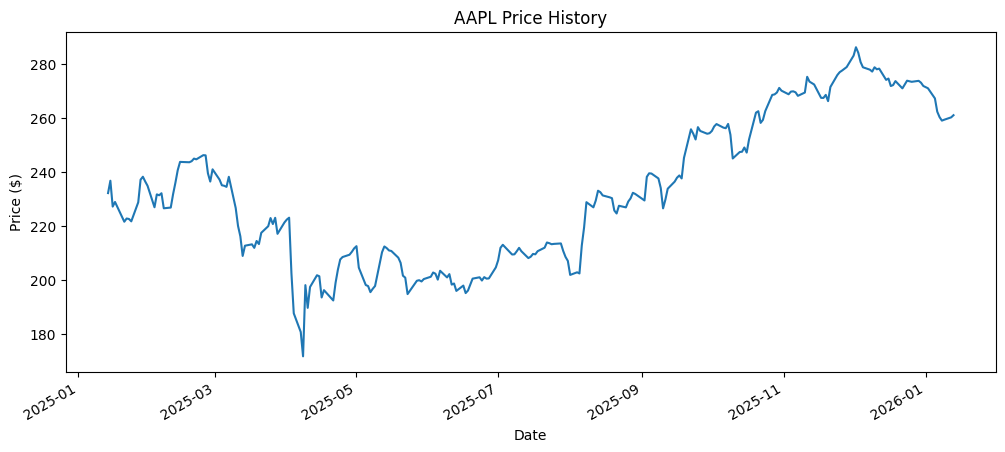

In [3]:
# Plot price history
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
hist['Close'].plot(ax=ax, title='AAPL Price History')
ax.set_ylabel('Price ($)')
plt.show()

In [4]:
# Get options chain
expirations = provider.get_expirations("AAPL")
print(f"Available expirations: {len(expirations)}")
print(f"Nearest: {expirations[0].strftime('%Y-%m-%d')}")

# Get nearest expiration chain
chain = provider.get_options_chain("AAPL")
print(f"\nOptions contracts: {len(chain)}")

# Show some ATM options
current_price = quote.last
atm_options = [c for c in chain if abs(c.strike - current_price) < 5]
print(f"\nNear-the-money options ({len(atm_options)} contracts):")
for opt in atm_options[:6]:
    print(f"  {opt.option_type.upper()} ${opt.strike:.0f}: Bid ${opt.bid:.2f}, Ask ${opt.ask:.2f}, IV {opt.implied_volatility:.1%}")

Available expirations: 22
Nearest: 2026-01-16
Error fetching options chain: cannot convert float NaN to integer

Options contracts: 0

Near-the-money options (0 contracts):


## 2. Options Pricing

In [5]:
from qwen.pricing import BlackScholes, BinomialTree, MonteCarlo

# Common parameters
spot = 150.0       # Current stock price
strike = 155.0     # Strike price
rate = 0.05        # Risk-free rate (5%)
vol = 0.25         # Volatility (25%)
time = 0.25        # Time to expiry (3 months)

# Black-Scholes pricing
bs = BlackScholes(spot, strike, rate, vol, time)

print("Black-Scholes Model:")
print(f"  Call Price: ${bs.call_price():.4f}")
print(f"  Put Price:  ${bs.put_price():.4f}")

# Greeks
greeks = bs.greeks("call")
print(f"\n  Call Greeks:")
print(f"    Delta: {greeks.delta:.4f}")
print(f"    Gamma: {greeks.gamma:.4f}")
print(f"    Theta: ${greeks.theta:.4f}/day")
print(f"    Vega:  ${greeks.vega:.4f}/1% vol")
print(f"    Rho:   ${greeks.rho:.4f}/1% rate")

Black-Scholes Model:
  Call Price: $6.1138
  Put Price:  $9.1883

  Call Greeks:
    Delta: 0.4602
    Gamma: 0.0212
    Theta: $-0.0494/day
    Vega:  $0.2977/1% vol
    Rho:   $0.1573/1% rate


In [ ]:
# Compare pricing models
binomial = BinomialTree(spot, strike, rate, vol, time, steps=100)
mc = MonteCarlo(spot, strike, rate, vol, time, num_paths=10000, seed=42)

print("Model Comparison (Call Option):")
print(f"  Black-Scholes:  ${bs.call_price():.4f}")
print(f"  Binomial Tree:  ${binomial.call_price():.4f}")

mc_result = mc.price_with_stats("call")
print(f"  Monte Carlo:    ${mc_result.price:.4f} ± ${mc_result.std_error:.4f}")
print(f"    95% CI: (${mc_result.confidence_interval[0]:.4f}, ${mc_result.confidence_interval[1]:.4f})")

In [6]:
# American vs European options (put)
euro_put = BinomialTree(spot, strike, rate, vol, time, steps=100, american=False)
amer_put = BinomialTree(spot, strike, rate, vol, time, steps=100, american=True)

print("American vs European Put:")
print(f"  European Put: ${euro_put.put_price():.4f}")
print(f"  American Put: ${amer_put.put_price():.4f}")
print(f"  Early Exercise Premium: ${amer_put.early_exercise_premium('put'):.4f}")

American vs European Put:
  European Put: $9.2006
  American Put: $9.4521
  Early Exercise Premium: $0.2515


In [7]:
# Implied Volatility calculation
market_price = 5.50  # Observed market price

bs_for_iv = BlackScholes(spot, strike, rate, 0.20, time)  # Initial vol guess
implied_vol = bs_for_iv.implied_volatility(market_price, "call")

print(f"Implied Volatility Calculation:")
print(f"  Market Price: ${market_price:.2f}")
print(f"  Implied Vol:  {implied_vol:.2%}")

# Verify
bs_verify = BlackScholes(spot, strike, rate, implied_vol, time)
print(f"  Verify Price: ${bs_verify.call_price():.2f}")

Implied Volatility Calculation:
  Market Price: $5.50
  Implied Vol:  22.94%
  Verify Price: $5.50


## 3. Paper Trading

In [8]:
from qwen.paper import PaperAccount, PaperBroker

# Create paper trading account
account = PaperAccount(starting_balance=100_000)
broker = PaperBroker(account, slippage=0.001, commission=1.0)

print(f"Initial Balance: ${account.cash:,.2f}")

# Execute some trades
broker.market_buy("AAPL", 100, price=150.0)
broker.market_buy("MSFT", 50, price=380.0)

print(f"\nAfter purchases:")
print(f"  Cash: ${account.cash:,.2f}")
print(f"  Positions: {account.position_symbols}")

# Check positions
prices = {"AAPL": 155.0, "MSFT": 385.0}  # Simulated price move
print(f"\nPortfolio with updated prices:")
print(account.positions_df(prices))

Initial Balance: $100,000.00

After purchases:
  Cash: $65,964.00
  Positions: ['AAPL', 'MSFT']

Portfolio with updated prices:
  symbol  quantity  cost_basis  current_price  market_value  unrealized_pnl  \
0   AAPL       100      150.15          155.0       15500.0           485.0   
1   MSFT        50      380.38          385.0       19250.0           231.0   

   unrealized_pnl_pct  
0            3.230103  
1            1.214575  


In [9]:
# Portfolio summary
print("\nPortfolio Summary:")
for key, value in account.summary(prices).items():
    if isinstance(value, float):
        print(f"  {key}: ${value:,.2f}" if 'pnl_percent' not in key.lower() else f"  {key}: {value:.2f}%")
    else:
        print(f"  {key}: {value}")


Portfolio Summary:
  cash: $65,964.00
  positions: 2
  portfolio_value: $100,714.00
  total_pnl: $714.00
  total_pnl_percent: 0.71%
  num_trades: 2


## 4. Backtesting

In [10]:
from qwen.backtest import BacktestEngine, Strategy, Signal
from qwen.backtest.strategy import SimpleMovingAverageCrossover

# Get data for backtesting
data = provider.get_historical("AAPL")
print(f"Backtesting on {len(data)} bars of AAPL data")
print(f"Period: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")

ImportError: cannot import name 'Signal' from 'qwen.backtest' (/Users/dakotacarrasco/Dev/active/qwen/qwen/backtest/__init__.py)

In [ ]:
# Create and run backtest
strategy = SimpleMovingAverageCrossover("AAPL", short_window=20, long_window=50)
engine = BacktestEngine(initial_capital=100_000, commission=1.0, slippage=0.001)

result = engine.run(strategy, data, symbol="AAPL")

print("\nBacktest Results:")
for key, value in result.summary().items():
    print(f"  {key}: {value}")

In [11]:
# Performance metrics
print("\nDetailed Metrics:")
print(result.metrics)


Detailed Metrics:


NameError: name 'result' is not defined

In [12]:
# Plot equity curve
result.plot()

NameError: name 'result' is not defined

In [13]:
# Compare multiple strategies
strategies = [
    SimpleMovingAverageCrossover("AAPL", short_window=10, long_window=30),
    SimpleMovingAverageCrossover("AAPL", short_window=20, long_window=50),
    SimpleMovingAverageCrossover("AAPL", short_window=50, long_window=200),
]

results = engine.run_multiple(strategies, data, symbol="AAPL")
comparison = engine.compare(results)
print("\nStrategy Comparison:")
comparison

NameError: name 'SimpleMovingAverageCrossover' is not defined

## 5. Building Your Own Strategy

Create a custom strategy by subclassing `Strategy` and implementing `on_bar()`:

In [14]:
class MeanReversionStrategy(Strategy):
    """Simple mean reversion strategy using Bollinger Bands."""
    
    def __init__(self, symbol: str, window: int = 20, num_std: float = 2.0):
        super().__init__(f"MeanReversion_{window}")
        self.symbol = symbol
        self.window = window
        self.num_std = num_std
    
    def on_bar(self, bar) -> list:
        if len(self._history) < self.window:
            return []
        
        closes = self._history['Close']
        sma = closes.rolling(self.window).mean().iloc[-1]
        std = closes.rolling(self.window).std().iloc[-1]
        
        upper_band = sma + self.num_std * std
        lower_band = sma - self.num_std * std
        
        current_price = bar['Close']
        
        signals = []
        
        # Buy when price touches lower band
        if current_price <= lower_band and not self.is_long(self.symbol):
            signals.append(self.buy(self.symbol, reason="Price at lower Bollinger Band"))
        
        # Sell when price touches upper band
        elif current_price >= upper_band and self.is_long(self.symbol):
            signals.append(self.close_position(self.symbol, reason="Price at upper Bollinger Band"))
        
        return signals

# Backtest the custom strategy
mean_rev = MeanReversionStrategy("AAPL", window=20, num_std=2.0)
mr_result = engine.run(mean_rev, data, symbol="AAPL")

print("Mean Reversion Strategy Results:")
for key, value in mr_result.summary().items():
    print(f"  {key}: {value}")

NameError: name 'engine' is not defined

## Next Steps

1. **Data Sources**: Configure Schwab API for real-time data
2. **Options Strategies**: Implement covered calls, iron condors, strangles
3. **Risk Management**: Add position sizing, stop losses
4. **Live Trading**: Connect paper broker to real market data feed